In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
df = pd.read_csv("hotels_data.csv")
df.head()

,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars
0,1,7/17/2015 0:00,8/12/2015 0:00,5,1178,1040,1,6,Best Western Plus Seaport Inn Downtown,3
1,1,7/17/2015 0:00,8/19/2015 0:00,5,1113,982,1,8,Best Western Plus Seaport Inn Downtown,3
2,1,7/17/2015 0:00,8/13/2015 0:00,5,4370,4240,1,3,The Peninsula New York,5
3,1,7/17/2015 0:00,7/26/2015 0:00,5,1739,1667,1,18,Eventi Hotel a Kimpton Hotel,4
4,1,7/17/2015 0:00,8/12/2015 0:00,5,1739,1672,1,3,Eventi Hotel a Kimpton Hotel,4


In [3]:
df.shape

(187848, 10)

In [4]:
df.duplicated().sum()

np.int64(19)

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df['Original Price'] = pd.to_numeric(df['Original Price'], errors='coerce')
df['Discount Price'] = pd.to_numeric(df['Discount Price'], errors='coerce')
df['discount_pct'] =(df['Original Price'] - df['Discount Price'])/df['Original Price']

df['Snapshot Date'] = pd.to_datetime(df['Snapshot Date'], errors='coerce')
df['Checkin Date'] = pd.to_datetime(df['Checkin Date'], errors='coerce')
df['days_until_checkin'] = (df['Checkin Date'] - df['Snapshot Date']).dt.days

In [7]:
df['Available Rooms'] = df['Available Rooms'].replace(-1,np.nan)
df['Available Rooms'] = df['Available Rooms'].fillna(df['Available Rooms'].median())

# EDA

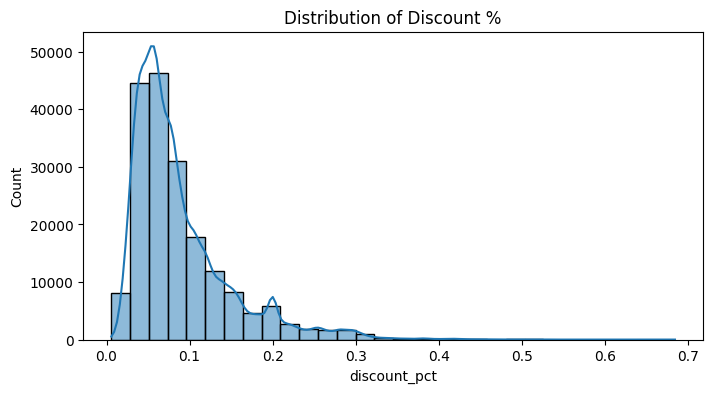

In [8]:
plt.figure(figsize=(8,4))
sns.histplot(df['discount_pct'], bins=30, kde=True)
plt.title("Distribution of Discount %")
plt.show()


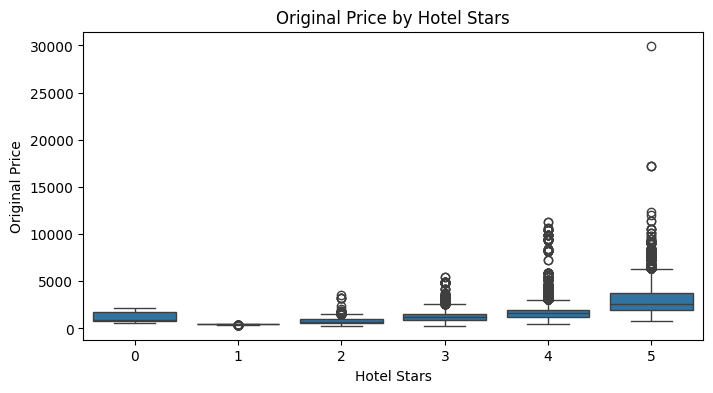

In [9]:
#BoxPlot
plt.figure(figsize=(8,4))
sns.boxplot(x='Hotel Stars', y='Original Price', data=df)
plt.title("Original Price by Hotel Stars")
plt.show()


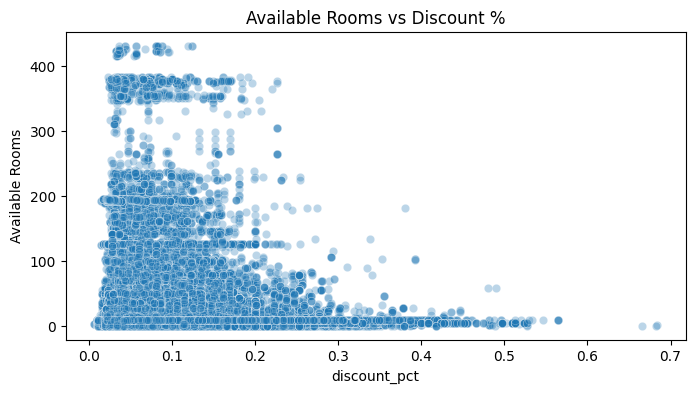

In [10]:
#Scatter Plot
plt.figure(figsize=(8,4))
sns.scatterplot(x='discount_pct', y='Available Rooms', alpha=0.3, data=df)
plt.title("Available Rooms vs Discount %")
plt.show()


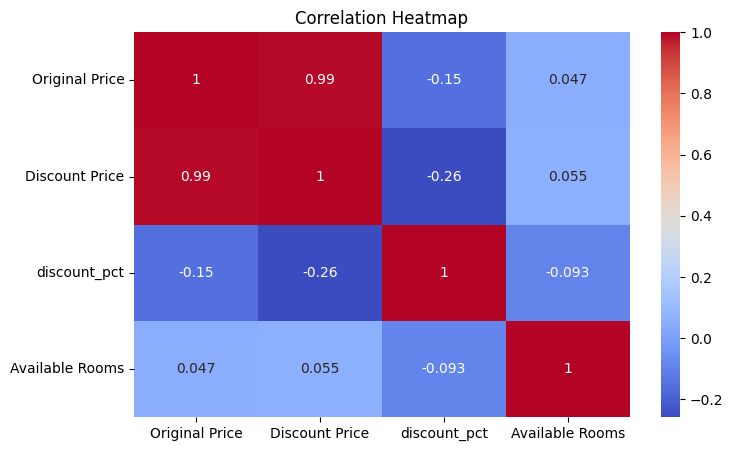

In [11]:
#Correlation
plt.figure(figsize=(8,5))
sns.heatmap(df[['Original Price','Discount Price','discount_pct','Available Rooms']].corr(),annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Feature Engineering

In [13]:
df['booked_rooms'] = df.groupby(['Snapshot Date','Hotel Name'])['Available Rooms'].transform('max') - df['Available Rooms']
model_df = df.dropna(subset=['booked_rooms','discount_pct']).copy()

Discount Code
4    5.796209
1    5.596220
3    5.337563
2    4.985621
Name: booked_rooms, dtype: float64


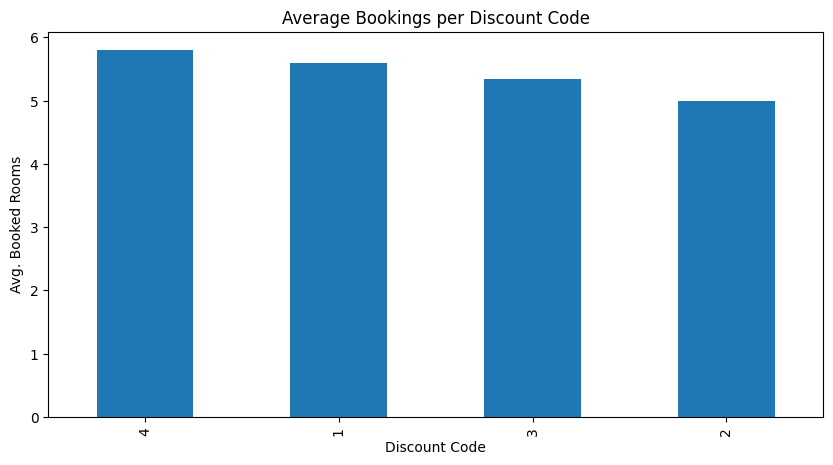

In [14]:
discount_effectiveness = df.groupby("Discount Code")["booked_rooms"].mean().sort_values(ascending=False)

print(discount_effectiveness)

# Plot
discount_effectiveness.plot(kind="bar", figsize=(10,5))
plt.title("Average Bookings per Discount Code")
plt.ylabel("Avg. Booked Rooms")
plt.xlabel("Discount Code")
plt.show()

In [15]:
numeric_features = ['discount_pct','days_until_checkin','Days','Original Price','Discount Price']
cat_features = ['Discount Code','Hotel Stars']

hotel_freq = model_df['Hotel Name'].value_counts().to_dict()
model_df['hotel_name_freq'] = model_df['Hotel Name'].map(hotel_freq).fillna(0)

features = numeric_features + cat_features + ['hotel_name_freq']
X = model_df[features]
y = model_df['booked_rooms']


In [16]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', cat_transformer, cat_features),
    ('hotel_freq','passthrough',['hotel_name_freq'])
])

#Linear Regression pipeline (with polynomial discount_pct) ---
poly_discount = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

transformers_lr = [
    ('poly_disc', poly_discount, ['discount_pct']),
    ('num_others', numeric_transformer, [c for c in numeric_features if c!='discount_pct']),
    ('cat', cat_transformer, cat_features),
    ('hotel_freq','passthrough',['hotel_name_freq'])
]

preprocessor_lr = ColumnTransformer(transformers_lr)


In [17]:
#Linear Regression
pipe_lr = Pipeline([
    ('pre', preprocessor_lr), 
    ('lr', LinearRegression())
])

# --- Random Forest pipeline ---
pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

pipe_xgb = Pipeline([
    ('pre', preprocessor),
    ('rf',XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Linear Regression
pipe_lr.fit(X_train, y_train)
pred_lr = pipe_lr.predict(X_test)
print("Linear Regression R2:", r2_score(y_test, pred_lr), "RMSE:", np.sqrt(mean_squared_error(y_test, pred_lr)))

#Random Forest Regressor
pipe_rf.fit(X_train, y_train)
pred_rf = pipe_rf.predict(X_test)
print("Random Forest R2:", r2_score(y_test, pred_rf), "RMSE:", np.sqrt(mean_squared_error(y_test, pred_rf)))

#XGBoost Regressor
pipe_xgb.fit(X_train,y_train)
pred_xgb = pipe_xgb.predict(X_test)
print('XGBoost R2:',r2_score(y_test,pred_xgb), 'RMSE:',np.sqrt(mean_squared_error(y_test,pred_xgb)))

Linear Regression R2: 0.028822824326430685 RMSE: 20.289938872979896
Random Forest R2: 0.6721037522674367 RMSE: 11.789617861759758
XGBoost R2: 0.5783630244577258 RMSE: 13.369059303284972


In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

hotel_agg = df.groupby('Hotel Name').agg({
    'discount_pct':'mean',
    'Available Rooms':'median',
    'Original Price':'mean',
    'Discount Code':'nunique'
}).rename(columns={'Available Rooms':'median_available_rooms'}).reset_index()

X = hotel_agg[['discount_pct','median_available_rooms','Original Price','Discount Code']].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

best_k, best_score = 0, -1
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k}, silhouette={score:.3f}")
    if score > best_score:
        best_k, best_score = k, score

print("Best k =", best_k, "with score =", best_score)

# 5. Fit final model
km_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
hotel_agg['cluster'] = km_final.fit_predict(X_scaled)

print(hotel_agg[['Hotel Name','cluster']].head())



k=2, silhouette=0.424
k=3, silhouette=0.403
k=4, silhouette=0.306
k=5, silhouette=0.363
k=6, silhouette=0.299
Best k = 2 with score = 0.4242126463839038
                             Hotel Name  cluster
0                  1 Hotel Central Park        0
1                       36 Hudson Hotel        0
2            6 Columbus - a SIXTY Hotel        0
3  70 Park Avenue Hotel a Kimpton Hotel        0
4                      AKA Central Park        1
